In [ ]:
#Copyright 2020 Soham Pachpande, Gehan Chopade, Arun Kumar
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

In [24]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.optim as optim

In [25]:
from dedup_lib.datasets import dedupDataset
from dedup_lib.models import NN

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [27]:
# Util Function

def binary_acc(y_pred, y_ground):

    # print(y_pred, y_ground)  
    y_pred_tag = torch.round(y_pred)
    # print(y_pred_tag, y_ground)  


    correct_results_sum = (y_pred_tag == y_ground).sum().float()
    # print(correct_results_sum)
    acc = correct_results_sum/y_ground.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

## Data Preparation
### Remove all data with entries which do not have embeddings

### Read Glove Embedding Model

The glove model weights have to be downloaded from https://nlp.stanford.edu/projects/glove/


Update the path in GLOVE_DIR accordingly

In [28]:
GLOVE_DIR="../pre-trained-models/glove.6B/"
dimension=100
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

### Read Data

In [29]:
data_path = "../data-extraction/1AllDuplicates_5NoDuplicates.csv"

df = pd.read_csv(data_path, usecols=['w1', 'w2', 'isDuplicate']).sample(frac=1).reset_index(drop=True)

df['w1'] = df['w1'].astype(str)
df['w2'] = df['w2'].astype(str)

### Remove words without embeddings

In [30]:
def hasEmbedding(w):
    if w.lower().strip() in embeddings_index:
        return True
    else:
        return False

df['w1_has_embedding']=df['w1'].apply(lambda x:hasEmbedding(x))
df['w2_has_embedding']=df['w2'].apply(lambda x:hasEmbedding(x))

In [31]:
df = df[df['w1_has_embedding']==True]
df = df[df['w2_has_embedding']==True]

df = df.drop(['w1_has_embedding', 'w2_has_embedding'], axis=1)
df = df.reset_index(drop=True)

In [32]:
df_train = df[:int(0.7*len(df))].reset_index(drop=True)
df_test = df[int(0.7*len(df)):].reset_index(drop=True)

# Train pytorch NN

In [33]:
train_set, test_set = dedupDataset(df_train, embeddings_index), dedupDataset(df_test, embeddings_index)
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=len(df_test))

In [34]:
model = NN(d=dimension).to(device)

In [35]:
# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

### Train Model

In [36]:
epochs=75
#forward loop
losses = []
accur = []
for i in range(epochs):
    for j,(x_train,y_train) in enumerate(train_loader):
        x_train,y_train = x_train.to(device), y_train.to(device)
        #calculate output
        output = model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))

        acc = binary_acc(output, y_train.reshape(-1,1))
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%5 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.6285766363143921	 accuracy : 88.0
epoch 5	loss : 0.35396116971969604	 accuracy : 88.0
epoch 10	loss : 0.30932220816612244	 accuracy : 88.0
epoch 15	loss : 0.26032376289367676	 accuracy : 88.0
epoch 20	loss : 0.1934332698583603	 accuracy : 95.0
epoch 25	loss : 0.14289167523384094	 accuracy : 97.0
epoch 30	loss : 0.11511888355016708	 accuracy : 97.0
epoch 35	loss : 0.09746905416250229	 accuracy : 98.0
epoch 40	loss : 0.08353416621685028	 accuracy : 98.0
epoch 45	loss : 0.07093213498592377	 accuracy : 98.0
epoch 50	loss : 0.056983839720487595	 accuracy : 98.0
epoch 55	loss : 0.040715888142585754	 accuracy : 99.0
epoch 60	loss : 0.027567295357584953	 accuracy : 99.0
epoch 65	loss : 0.019716385751962662	 accuracy : 100.0
epoch 70	loss : 0.014741906896233559	 accuracy : 100.0


### Test Model

In [37]:
y_truth_list = []
y_pred_list = []
model.eval()
with torch.no_grad():
    for j,(x_test,y_test) in enumerate(test_loader):
        x_test,y_test = x_test.to(device), y_test.to(device)
        #calculate output
        output = model(x_test)

        acc = binary_acc(output, y_test.reshape(-1,1))

In [39]:
y_pred = torch.round(output.reshape(-1))

In [40]:
y_pred_arr = np.asarray(y_pred.cpu())
y_test_arr = np.asarray(y_test.cpu())

### Stats about results

In [42]:
from sklearn.metrics import roc_curve, classification_report
from dedup_lib.utils import makeCFwithStats

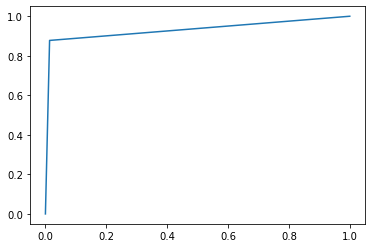

In [43]:
fpr, tpr, thresholds = roc_curve(y_test_arr, y_pred_arr)
plt.plot(fpr,tpr)
plt.show()

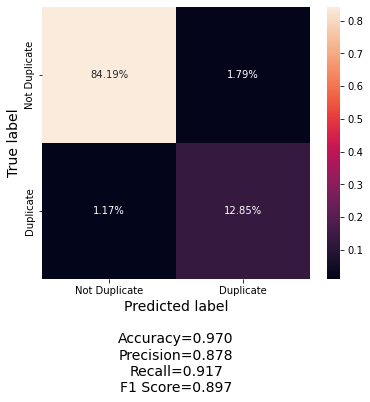

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1096
         1.0       0.92      0.88      0.90       188

    accuracy                           0.97      1284
   macro avg       0.95      0.93      0.94      1284
weighted avg       0.97      0.97      0.97      1284



In [44]:
makeCFwithStats(y_test_arr, y_pred_arr)
print(classification_report(y_test_arr, y_pred_arr))